# Single method point simulation

## Introduction
There are several cases when one may be interested to evaluate a method as an independent entity from a full simulation domain. One may be interested in exploring a snow melt routine, or an evapotranspiration calculation and comparing it with local point observations. Or, you may be interested to explore a method and evaluate the parameter sensitivity.

While Shyft provides a toolbox for running distributed hydrologic simulations, we recognize the need for point-based simulations as well. We have provided several different mechanisms for running the models. The main concept to be aware of is that while we demonstrate and build on the use of a 'configuration', nearly all simulation functionality is also accessible with pure python. It is recommended, if you intend to use Shyft for any kind of hydrologic exploration, to become familiar with the API functionality.

In this python notebook, you will learn how to use the Shyft API to directly access single methods used in model stacks. You will learn how to run them without running a complete model stack and without using any 'configuration' layer or simulation. This functionality allows one to explore certain model routines as a point model (e.g. for comparison of model results with point observations), conducting sensitivity studies, and investigating the details of a certain routine.

#### To achive this, we will
#### 1. create a synthetic data set which we will use to run the model
#### 2. convert the input data to shyft-conform data-types by using Shyft's API functionality
#### 3. run a certain routine using the Shyft API (we will use the HBV snow routine as an example)
#### 4. change the default parameters and initial state

In [1]:
# Pure python modules and jupyter notebook functionality
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%pylab inline
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## The Shyft Environment
First we will create the shyft specific environment. Start by setting the path for your shyft build this should point to the directory that is created when you clone shyft (assuming you have built shyft there and not installed it to your system python). If you followed the recommendations in the README, then you will have cloned three git repos in a parallel structure and can point to the shyft repository:

In [2]:
# set path to the shyft git folder (assuming you built shyft there)
shyft_path = os.path.abspath("../../../shyft")
sys.path.insert(0, shyft_path)

# Note: you could achieve the same by setting a PYTHONPATH

In [3]:
# once the shyft_path is set correctly, you should be able to import shyft modules, e.g. the shyft API
from shyft import api

### 1. Synthetic forcing data set

In [4]:
n = 365 # nr of time steps: 1 year, daily data
precip_bool = [0 if r <0.7 else 1 for r in np.random.rand(n)]
precip = [i*j*15 for i,j in zip(np.random.rand(n),precip_bool)] # precip [mm/day]
temp_noise = (np.random.rand(n)-0.5) * 15
temp = 10 * np.sin(-np.arange(n)*2*np.pi/n) + temp_noise # temperatur [deg C]
day = np.arange(n) # day of water year

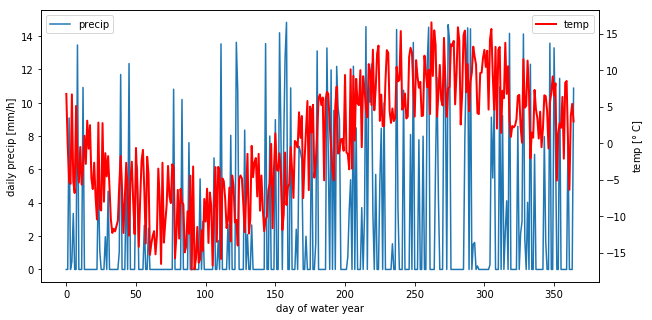

In [5]:
# Let's have a look to the synthetic forcing data by plotting it
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(day,precip, label='precip')
ax2.plot(day, temp, c='r', lw=2, label='temp')
ax1.set_ylabel('daily precip [mm/h]')
ax2.set_ylabel('temp [$°$ C]')
ax1.set_xlabel('day of water year')
ax1.legend(loc=2); ax2.legend(loc=1)


### 2. Convert input data to shyft-conform data-types by using api functionality

In [6]:
# Every routine (e.g. for computing the snowpack, evapotranspiration, discharge response, ...)
# has a "Calculator" class, here shown for the HbvSnow routine:
type(api.HbvSnowCalculator)

Boost.Python.class

In [7]:
# Let's print some information about the calculator class
api.HbvSnowCalculator?

In [8]:
# Using tab-completion, we can check out the methods the calculator-class is providing
# Try it out by typing "api.HbvSnowCalculator." and press the "tab" key on your keyboard:
api.HbvSnowCalculator.

SyntaxError: invalid syntax (<ipython-input-8-208d5e005158>, line 3)

In [9]:
# Obviously, there is a method called "step".
# This method can be used to do the time stepping. E.g. if we have a certain model state s0 at time t0,
# the step function calculates the model state s1 at time t0+dt, where dt is the time step in seconds.

# The Calculator classes of all routines have a similar method.
# In most cases this method is called "step", such as here.
# Let's check out the details of the "step" method in more detail:
api.HbvSnowCalculator.step?


In [10]:
# The docstring of this method tells us, that the follwoing arguments are required to step
# forward by one time step dt:
# - model state of type "HbvSnowState"
# - model response of type "HbvSnowResponse"
# - start time t0 of type "int"
# - end time t1 of type "int"
# - model parameters of type "HbvSnowParameter"
# - precipitation input of type "float"
# - temperature input of type "float"

# If we can provide the above listed input, we can step the model forward.

In [11]:
# The shyft api supports quite some functionality for time and time series handling
# lets assume that the synthetic data is daily data, starting at October 1st, 2016
utc = api.Calendar() # provides shyft build-in functionality for date/time handling
t_start = utc.time(2016, 10, 1) # starting at the beginning of the water year 2017
dt = api.deltahours(24) # returns daily timestep in seconds

In [12]:
# Let's now create Shyft time series from the supplied lists of precipitation and temperature.
# First, we need a time axis, which is defined by a starting time, a time step and the number of time steps.
ta = api.TimeAxis(t_start, dt, n)

In [13]:
# We now can transform our python-type lists to Shyft type time series.
# To get more information about the time series, have a look into the
# "ts-convolve" and the "partition_by_and_percentiles" notebooks.

# First, we convert the lists to shyft internal vectors of double values:
temp_dv = api.DoubleVector.from_numpy(temp)
precip_dv = api.DoubleVector.from_numpy(precip)

# The TimeSeries class has some powerfull funcionality (however, this is not subject of matter in here).
# For this reason, one needs to specify how the input data can be interpreted:
# - as instant point values at the time given (e.g. such as most observed temperatures), or
# - as average value of the period (e.g. such as most observed precipitation)
# This distinction can be specified by passing the respective "point_interpretation_policy",
# provided by the API:
instant = api.point_interpretation_policy.POINT_INSTANT_VALUE
average = api.point_interpretation_policy.POINT_AVERAGE_VALUE

# Finally, we create shyft time-series as follows:
# (Note: This step is not necessarily required to run the single methods.
#  We could also just work with the double vector objects and the time axis)
temp_ts = api.TimeSeries(ta, temp_dv, point_fx=instant)
precip_ts = api.TimeSeries(ta, precip_dv, point_fx=average)

### 3. Run a method using the SHyFT API

In [14]:
# To run the routine now step by step, we first need to instanciate an instance of the calculator object.
# To instanciete the calculator class we need to provide the starting state of our model 
# (the values of all state variables at time t0) and the model parameters at time t0 as arguments.
# The model state will later be updated by the routine. If we would like to, we can update the model
# parameters as well. More to this further down.

parameter = api.HbvSnowParameter()
state = api.HbvSnowState()
state.distribute(parameter)  # the state also contains a snow distribution, these needs to match parameter
response = api.HbvSnowResponse()

calculator = api.HbvSnowCalculator(parameter)

In [15]:
# Let's first have a look to the starting state of our model: you can use tab completing
# to investigate the state-variables of the HbvSnow algorithm (try out!)
state.sca

0.0

In [16]:
# we now can simply run the routine step by step:
try:
    del outflow
except:
    pass
for i in range(n):
    P = precip_ts.v[i]
    T = temp_ts.v[i]
    t0 = t_start + i*dt
    t1 = t0 + dt
    calculator.step(state, response, t0, t1, P, T)

In [17]:
# However, so far we didn't get any information about state and response variables from the model.
# Let's repeat the run - this time collecting the state and response variables.
# (Note: Collecting state and response variables is done by so called "collectors" when running
#  a model stack available in shyft, e.g. the pt_gs_k stack. Here, we simply append the model state and
#  response of each time step to shyft's double vectors.)

In [18]:
swe = api.DoubleVector() # double vector to collect snow water equivalent, a state variable of HbvSnow; the double vector is empty so far
outflow = api.DoubleVector() # double vector to collect outflow from the snow pack, a response variable of HbvSnow.

In [19]:
state = api.HbvSnowState() # reset the model state to default
state.distribute(parameter) # recall, hbv.snow state have a distribution in bins, number of bins must also initialize
for i in range(n):
    P = precip_ts.v[i]
    T = temp_ts.v[i]
    t0 = t_start + i*dt
    t1 = t0 + dt
    calculator.step(state, response, t0, t1, P, T)
    swe.append(state.swe) # appending the current model state to the double vector
    outflow.append(response.outflow) # appending the current model respnse to the double vector

In [20]:
# Let's also create a time axis suiting to the collected state and response:
# (Note: the first collection of a state and response refers to t_start+dt)
ta_state = api.TimeAxis(t_start+dt, dt, n-1)
# Using this time axis, we can create a list of datetime objects which will use during plotting
dates = [datetime.datetime.utcfromtimestamp(t) for t in ta_state.time_points]

In [21]:
print(len(outflow))

365


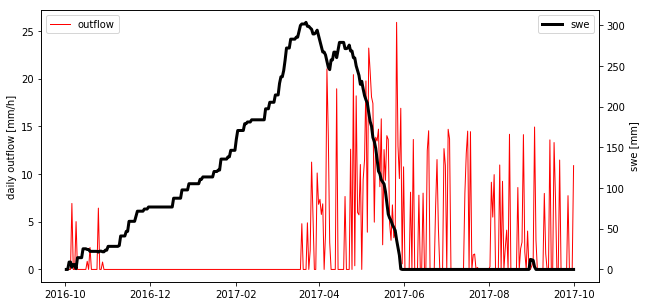

In [22]:
# Let's plot the data we received from HbvSnow
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(dates, outflow, c='r', lw=1, label='outflow')
ax2.plot(dates, swe, c='k', lw=3, label='swe')
ax1.set_ylabel('daily outflow [mm/h]')
ax2.set_ylabel('swe [mm]')
ax1.legend(loc=2); ax2.legend(loc=1)

### 4. Changing parameters and initial state

In [23]:
# So far we ran the routine only with the default parameters and state.
# Shyft provides the functionality to set starting state and parameters on the fly as needed.

In [24]:
# Use tab completion to investigate on which parameters HbvSnow depends

In [ ]:
parameter.

In [24]:
# Use the 'help' functionality to get information about a certain parameter, e.g. cx

In [ ]:
parameter.cx?

In [ ]:
# let's look at the default value of the parameter cx
print(parameter.cx)

In [ ]:
# lets now set a parameter to a new value and rerun HbvSnow and replot the outcome

In [25]:
parameter.cx = 2.0

In [26]:
swe = api.DoubleVector()
outflow = api.DoubleVector()
state = api.HbvSnowState() # reset the model state to default
state.distribute(parameter) # again, the snow.distribution needs to match the parameter, 
calculator = api.HbvSnowCalculator(parameter)
for i in range(n):
    P = precip_ts.v[i]
    T = temp_ts.v[i]
    t0 = t_start + i*dt
    t1 = t0 + dt
    calculator.step(state, response, t0, t1, P, T)
    swe.append(state.swe) # appending the current model state to the double vector
    outflow.append(response.outflow) # appending the current model respnse to the double vector

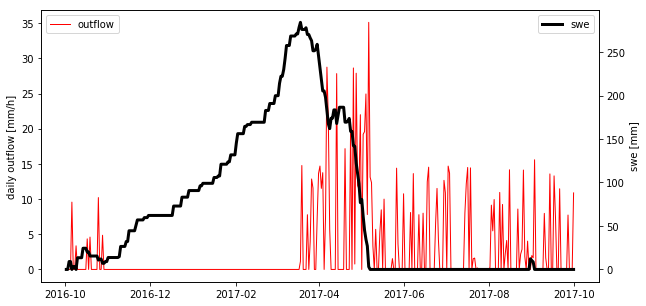

In [27]:
# Let's plot the data we received from HbvSnow
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(dates, outflow, c='r', lw=1, label='outflow')
ax2.plot(dates, swe, c='k', lw=3, label='swe')
ax1.set_ylabel('daily outflow [mm/h]')
ax2.set_ylabel('swe [mm]')
ax1.legend(loc=2); ax2.legend(loc=1)

In [28]:
# to complete the training, let's also set a different starting state, e.g. an already existing snow pack:

In [29]:
swe = api.DoubleVector()
outflow = api.DoubleVector()
state = api.HbvSnowState() # reset the model state to default
state.distribute(parameter) # recall, snow state keeps distribution, an unknown number of bins until told by distribute
parameter = api.HbvSnowParameter() # reset the model parameters to default

In [30]:
# setting a certain starting state
state.sca = 1.0
state.swe = 150.0

In [31]:
# rerun the model
calculator = api.HbvSnowCalculator(parameter)
for i in range(n):
    P = precip_ts.v[i]
    T = temp_ts.v[i]
    t0 = t_start + i*dt
    t1 = t0 + dt
    calculator.step(state, response, t0, t1, P, T)
    swe.append(state.swe) # appending the current model state to the double vector
    outflow.append(response.outflow) # appending the current model respnse to the double vector

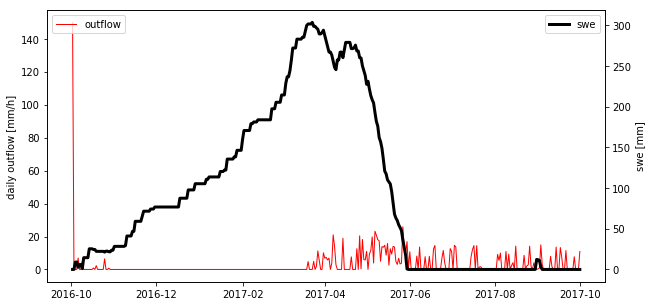

In [32]:
# Let's plot the data we received from HbvSnow
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(dates, outflow, c='r', lw=1, label='outflow')
ax2.plot(dates, swe, c='k', lw=3, label='swe')
ax1.set_ylabel('daily outflow [mm/h]')
ax2.set_ylabel('swe [mm]')
ax1.legend(loc=2); ax2.legend(loc=1)